**Tester le code avec des événements plus probable!!!**
## To do list:
* Q1-1
#####* Splitting (Diane) (faudrait jouer avec le nombre de niveaux de splitting, donc avec la valeur de la variable "seuil", pour voir ce qui donne la meilleure précision)
#####* Echantillonage d'importance (Peng-Wei) (C'est bon!!, à tester différent f)
#####* Chaîne de Markov
#####* Graphique : Comparaison de différentes méthodes.

* Q1-2
#####* Quantile processus AR(1) (comme dans calcul liste_a Q1-1) (Diane)
#####* Quantile échantillonnage d'importance (Diane)
* Q2
#####* M-C (Peng-Wei)

* Q3
# Finished :
* Q1
#####* Monte-Carlo naïve
* Q


In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as sps

## Q1

Dans cette première modélisation simplifiée, on considère donc que le prix $P_t$ est un processus de Poisson de paramètres $\lambda, \nu$ où $\nu$ est la loi des incréments $J_n$. 

Pour un temps d'attente moyen entre deux sauts de $300s$, on prend $\lambda = \dfrac{1}{300}$


In [0]:
# On identifie le processus par le processus de Poisson composé, qui finit à un temps fixé T
# On crée des fonctions pour modéliser le processus.

#### On définit nu, la loi des incréments
# Ancien : plus lent
saut_1_ancien = lambda x: np.random.choice([-1, 1], size=x, replace=True, p=[0.5, 0.5]) #correspond à m=1
saut_2_ancien = lambda x: np.random.choice([-3, -2, -1, 1, 2, 3], size=x, replace=True, p=0.5*np.array([1/6, 1/3, 1/2, 1/2, 1/3, 1/6])) #correspond à m=3

# Nouveau : beaucoup plus vite
value_1 = np.array([-1, 1])
value_2 = np.array([-3, -2, -2, -1, -1, -1, 1, 1, 1, 2, 2, 3])
saut_1 = lambda x : value_1[np.random.randint(low=2, size=x)]
saut_2 = lambda x : value_2[np.random.randint(low=12, size=x)]

# Les paramètres
P0 = 35
T = 4*60*60
lamb = 1/300

###Q1-0 Simulation de trajectoire

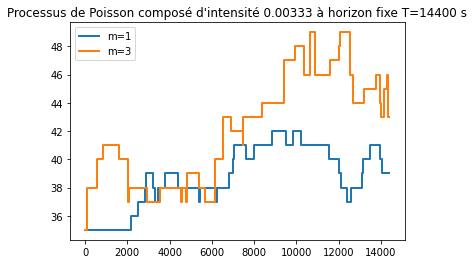

In [0]:
#Simulation des temps entre les sauts plutôt que directement N puis uniforme (évite d'avoir à trier en NlogN les temps des sauts)

def liste_sauts(lamb,T,P0,saut):
    t=np.random.exponential(lamb)
    liste_t= np.array([0,np.random.exponential(1/lamb)])
    liste_increments= np.array([0])
    while liste_t[-1]<T:
        liste_increments = np.append(liste_increments,saut(1))
        liste_t=np.append(liste_t,liste_t[-1]+np.random.exponential(1/lamb))
    liste_t[-1]= T
    liste_increments=np.append(liste_increments,0)
    liste_prix = P0 + np.cumsum(liste_increments)

    return liste_t,liste_prix


liste_t_1, liste_prix_1 = liste_sauts(lamb,T,P0,saut_1)
plt.step(liste_t_1, liste_prix_1, where="post", label="m=1", linewidth=2.0)

liste_t_2, liste_prix_2 = liste_sauts(lamb,T,P0,saut_2)
plt.step(liste_t_2, liste_prix_2, where="post", label="m=3", linewidth=2.0)
plt.title("Processus de Poisson composé d'intensité {:04.5f} à horizon fixe T={} s".format(lamb,T), fontsize=12)
plt.legend(loc="best")


### Q1 -1 Probabilité de ruine


#### Monte-Carlo Naif

In [0]:
## Monte-Carlo Naif

def liste_prix_sauts(lamb,T,P0,saut):
    N = np.random.poisson(lamb*T) #le nombre de sauts suit une loi de Poisson de paramètre lambda*T
    liste_increments = saut(N)
    liste_prix = P0 + np.cumsum(liste_increments)

    return liste_prix


def MC_naif(M,lamb,T,P0,saut): 
    liste_bool_inf_0 = np.zeros(M) 

    for l in range(M):
        liste_prix = liste_prix_sauts(lamb,T,P0,saut) #prix juste après les sauts
        if np.min(liste_prix) <0:
            liste_bool_inf_0[l] = 1

    p_r = np.mean(liste_bool_inf_0)
    return p_r



In [0]:
%%time

P0 = 35 #35 en théorie mais on commence par tester avec plus bas
T = 4*60*60 #conversion en secondes
lamb = 1/300
M = int(1e6)

p_r = MC_naif(M,lamb,T,P0,saut_2)

R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiancee
print(p_r)
print(R_IC)

#donne 0.00254 pour P0=20 et M=10^5 et m=1(total time 5.02 s)
#m=3 P0=35 M=10^6: proba = 0.004341

0.004402
0.00012975470009396036
CPU times: user 58 s, sys: 11.9 ms, total: 58 s
Wall time: 58 s


#### Monte-Carlo Naif - numba

In [0]:
## Monte-Carlo Naif avec numba
from numba import jit

@jit(nopython=True)
def inf_echantillon(N, J, P0): # Function is compiled to machine code when called the first time
  ruines = 0
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        ruine = 1
        break
    ruines += ruine
  return ruines

def trajectoire(P0, T, lamb, saut, size):
  if size > int(1e7):
    sizes = size
    size = int(1e7)
    proba = 0
    for i in range(sizes // size):
      N = np.random.poisson(lam=lamb * T, size=size + 1)
      N[0] = 0
      N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                        # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
      J = saut(N[-1] + 1)
      res = inf_echantillon(N, J, P0)
      proba += res
    proba /= sizes
    return proba
  else:
    N = np.random.poisson(lam=lamb * T, size=size + 1)
    N[0] = 0
    N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                      # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
    J = saut(N[-1] + 1)
    res = inf_echantillon(N, J, P0)
    proba = res / size
    return proba

In [0]:
%%time
size = int(1e9)
p_r = trajectoire(P0, T, lamb, saut_1, size=size)

R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(size) #rayon de l'intervalle de confiance

print(p_r)
print(R_IC)

#print(trajectoire(P0, T, lamb, saut_1, size=int(1e7)))

#m=1
#0.00279 pour P0 = 20 M = 10^5 (total time 161 ms)
#5e-07 pour P0=35 et M=10^7 total time : 16.1 s
#quand on fait la moyenne sur 10 essais à M=10^7, on trouve proba_emp = 2.009975 e-7 et sigma_emp = 3.6 e-7 (tout ça pour m=1)

#m=3
#proba_emp=0.0043245, sigma_emp = 7.1273066441679e-05

3.53e-07
3.6825050187366557e-08
CPU times: user 8min 1s, sys: 2.09 s, total: 8min 3s
Wall time: 8min 3s


#### Splitting et MCMC

In [0]:
#Archive ancienne version non optimisée par super peng-wei

def NiveauxSplitting(a,seuil,n,lamb,T,p,P0,saut):

    """
    Fonction qui renvoie une estimation des niveaux
    de splitting a_1, a_2, ..., a_k tels que P(Phi_T <= a_k | Phi_T <= a_{k-1}) = 0.1 = seuil
    (où Phi_T : inf de P_t pour t dans [0;T])
    Ces niveaux sont des quantiles d'une loi conditionnelle.
    On utilise l'inversion de la fonction de repartition empirique de 
    cette loi afin d'estimer un quantile par
    le quantile empirique.
    On a a = a_k < a_{k-1} < ... < a_0= + infini (dans notre problème, a = 0)
    La fonction renvoie quantiles = [a_1, ..., a_k]
    """
    ## Estimation du premier niveau a_1: c'est le 
    ## quantile d'une loi non conditionnelle.
    ## On l'estime ici par la methode ergodique

    liste_Phi = np.zeros(n)

    liste_sauts = liste_sts(lamb,T,saut)

    for l in range(n):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_Phi[l] = Phi(liste_sauts,P0)

    liste_Phi.sort()

    quantiles = np.array([liste_Phi[int(np.ceil(seuil*n))-1]])    

    while quantiles[-1] > a:
        print("Inside while")
        liste_Phi = np.zeros(n)

        
        while Phi(liste_sauts,P0)>=quantiles[-1]:
            liste_sauts = liste_sts(lamb,T,saut)
        ## Simulation du processus AR(1) conditionnel
    
        for l in range(n):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            new_liste_sauts = tri_temps(new_liste_sauts)

            if Phi(new_liste_sauts,P0)<quantiles[-1]:
                liste_sauts = new_liste_sauts

            liste_Phi[l] = Phi(liste_sauts,P0)
    
        liste_Phi.sort()
        quantiles = np.append(quantiles, liste_Phi[int(np.ceil(seuil*n))-1] )

    
    ## On selectionne les niveaux a_{k-1},..., a_1 strictement au dessus de a
    quantiles = quantiles[:-1]
    ## On rajoute a
    quantiles = np.append(quantiles,a)

    return quantiles


def Phi(liste_sauts,P0):#fonction qui renvoie l'inf des valeurs de X aux instants de saut
    #ie l'inf de P0+cumsum(incréments) 
    if len(liste_sauts[0]) == 0:
        return P0
    liste_prix = P0+np.cumsum(liste_sauts[1,:])
    prix_min = np.min(liste_prix)
    return prix_min

def liste_sts(lbda,T,saut):
    
    N = np.random.poisson(lbda*T)
    liste_temps_sauts = np.random.uniform(low = 0, high = T, size = N)
    liste_temps_sauts_triee = [np.sort(liste_temps_sauts)]
    liste_increments = [saut(N)]
    #renvoie un array de N colonnes et 2 lignes: 1ere ligne pour les temps des sauts (T_n), deuxième ligne pour leurs amplitudes (J_n)
    return np.concatenate((liste_temps_sauts_triee,liste_increments),axis=0)

def tri_temps(new_liste_sauts):
    ordre = [new_liste_sauts[0,:].argsort()]
    liste_sauts_triee = np.take_along_axis(new_liste_sauts, np.concatenate((ordre,ordre),axis=0), axis=1) 
    return liste_sauts_triee


def MCMC(M,p,lamb,liste_a,P0,saut): 

    liste_pi = np.zeros(len(liste_a)) #estimateurs des probabilités conditionnelles

    liste_indicatrices = np.zeros(M,dtype=bool) 
    """
    le k-ieme élém. de liste_indicatrices vaut True si le prix devient négatif avant l'instant T lors du k-ieme essai; False sinon
    """

    #Loi non conditionnelle
    
    liste_sauts = liste_sts(lamb,T,saut) 


    for l in range(M):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_indicatrices[l] = (Phi(liste_sauts,P0)<liste_a[0])

    liste_pi[0] = np.mean(liste_indicatrices)
    
        


    for k in range(1,len(liste_a)):
        liste_indicatrices = np.zeros(M,dtype=bool)  

        #Initialisation 

        while Phi(liste_sauts,P0)>=liste_a[k-1]:
          
            liste_sauts = liste_sts(lamb,T,saut)

      
        for l in range(M):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            new_liste_sauts = tri_temps(new_liste_sauts)

            if Phi(new_liste_sauts,P0)< liste_a[k-1]:
                liste_sauts = new_liste_sauts
            liste_indicatrices[l] = (Phi(liste_sauts,P0) < liste_a[k])


        liste_pi[k] = np.mean(liste_indicatrices)
    

    proba_prix_negatif = np.prod(liste_pi)
        
    return proba_prix_negatif

In [0]:
## Splitting et MCMC - Méthode 3 (optimisé)
def NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut):

    """
    Fonction qui renvoie une estimation des niveaux
    de splitting a_1, a_2, ..., a_k tels que P(Phi_T <= a_k | Phi_T <= a_{k-1}) = 0.1 = seuil
    (où Phi_T : inf de P_t pour t dans [0;T])
    Ces niveaux sont des quantiles d'une loi conditionnelle.
    On utilise l'inversion de la fonction de repartition empirique de 
    cette loi afin d'estimer un quantile par
    le quantile empirique.
    On a a = a_k < a_{k-1} < ... < a_0= + infini (dans notre problème, a = 0)
    La fonction renvoie quantiles = [a_1, ..., a_k]
    """
    ## Estimation du premier niveau a_1: c'est le 
    ## quantile d'une loi non conditionnelle.
    ## On l'estime ici par la methode ergodique

    liste_Phi = np.zeros(M1)

    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Phi_min = 100000
    
    for l in range(M1):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_Phi[l] = Phi(liste_sauts,P0)
        if liste_Phi[l] < Phi_min:
            liste_sauts_min = np.copy(liste_sauts)
            Phi_min = liste_Phi[l]

    liste_Phi.sort()
    
    quantiles = np.array([liste_Phi[int(np.ceil(seuil*M1))-1]])    

    while quantiles[-1] > a:
        #print("Inside while", quantiles[-1], Phi(liste_sauts_min, P0))
        if quantiles[-1] <= a + 1:
            quantiles = np.append(quantiles, a)
            break
        
        liste_Phi = np.zeros(M1)
        
        liste_sauts = np.copy(liste_sauts_min)
        phi_actual = Phi(liste_sauts, P0)
        Phi_min = 100000

        ## Simulation du processus AR(1) conditionnel
    
        for l in range(M1):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            
            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)
            
            phi_local = Phi(new_liste_sauts,P0)
            
            if phi_local<quantiles[-1]:
                liste_sauts = new_liste_sauts
                phi_actual = phi_local

            liste_Phi[l] = phi_actual
            if liste_Phi[l] < Phi_min:
                liste_sauts_min = np.copy(liste_sauts)
                Phi_min = liste_Phi[l]

        liste_Phi.sort()
        quantile = liste_Phi[int(np.ceil(seuil*M1)) - 1]
        if quantile >= quantiles[-1]:
            quantiles = np.append(quantiles, quantiles[-1] - 1)
        else:
            quantiles = np.append(quantiles, quantile)


    ## On selectionne les niveaux a_{k-1},..., a_1 strictement au dessus de a
    quantiles = quantiles[:-1]
    ## On rajoute a
    quantiles = np.append(quantiles,a)

    return quantiles


from numba import jit

@jit(nopython=True)
def Phi(liste_sauts, P0): # Function is compiled to machine code when called the first time
    prix_min = P0
    if len(liste_sauts[0]) == 0:
        return P0
    for i in liste_sauts[1, :]:
        P0 += i
        if P0 < prix_min:
            prix_min = P0
    return prix_min

'''def Phi(liste_sauts,P0):#fonction qui renvoie l'inf des valeurs de X aux instants de saut
    #ie l'inf de P0+cumsum(incréments) 
    if len(liste_sauts[0]) == 0:
        return P0
    liste_prix = P0+np.cumsum(liste_sauts[1,:])
    prix_min = np.min(liste_prix)
    return prix_min'''

def liste_sts(lbda, T, saut):
    N = np.random.poisson(lbda*T)
    liste_sauts = np.zeros((2, N))
    liste_sauts[0, :] = np.sort(np.random.uniform(low=0, high=T, size=N))
    liste_sauts[1, :] = saut(N)
    #renvoie un array de N colonnes et 2 lignes: 1ere ligne pour les temps des sauts (T_n), deuxième ligne pour leurs amplitudes (J_n)
    return liste_sauts
    #liste_temps_sauts = np.random.uniform(low = 0, high = T, size = N)
    #liste_temps_sauts_triee = [np.sort(liste_temps_sauts)]
    #liste_increments = [saut(N)]
    #return np.concatenate((liste_temps_sauts_triee,liste_increments),axis=0)

@jit(nopython=True)
def new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt):
    i = 0
    j = 0
    k = 0
    # Merge two listes triées
    while i < nc:
        T1 = coloriage[0, i]
        while j < nt and liste_sauts_tilde[0, j] < T1:
            new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
            j += 1
            k += 1
        new_liste_sauts[:, k] = coloriage[:, i]
        i += 1
        k += 1
    while j < nt:
        new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
        j += 1
        k += 1
    return new_liste_sauts

def tri_temps(new_liste_sauts):
    ordre = [new_liste_sauts[0,:].argsort()]
    liste_sauts_triee = np.take_along_axis(new_liste_sauts, np.concatenate((ordre,ordre),axis=0), axis=1) 
    return liste_sauts_triee


def MCMC(M2,p,lamb,liste_a,P0,saut):

    liste_pi = np.zeros(len(liste_a)) #estimateurs des probabilités conditionnelles

    liste_indicatrices = np.zeros(M2,dtype=bool) 
    """
    le k-ieme élém. de liste_indicatrices vaut True si le prix devient négatif avant l'instant T lors du k-ieme essai; False sinon
    """

    #Loi non conditionnelle
    
    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Found = False

    for l in range(M2):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        if Phi(liste_sauts, P0) < liste_a[0]:
            liste_indicatrices[l] = True
            if not Found:
                liste_sauts_min = np.copy(liste_sauts)
                Found = True

    liste_pi[0] = np.mean(liste_indicatrices)
    
    for k in range(1,len(liste_a)):
        liste_indicatrices = np.zeros(M2,dtype=bool)  

        #Initialisation 
        liste_sauts = np.copy(liste_sauts_min)
        phi_actual = Phi(liste_sauts, P0)
        
        Found = False

        for l in range(M2):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)

            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)

            phi_local = Phi(new_liste_sauts, P0)
            
            if phi_local < liste_a[k-1]:
                liste_sauts = new_liste_sauts
                phi_actual = phi_local

            if phi_actual < liste_a[k]:
                liste_indicatrices[l] = True
                if not Found:
                    liste_sauts_min = np.copy(liste_sauts)

        liste_pi[k] = np.mean(liste_indicatrices)
    
    proba_prix_negatif = np.prod(liste_pi)
    return proba_prix_negatif

In [0]:
%%time

M = int(1e4) 
a=0

#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
seuil = 0.03
p=0.5

liste_a = NiveauxSplitting(a,seuil,M,lamb,T,p,P0,saut_1) #exemple: [21. 12.  6.  0.] pour M = 10^4, seuil=0.03 et p=0.5

n=10
probas = np.zeros(n)
M = int(1e4)

for i in range(n):
    probas[i] = MCMC(M, p,lamb,liste_a,P0,saut_1)

p_r = np.mean(probas)
sigma_emp = np.std(probas)/np.sqrt(n) #écart-type empirique de la moyenne des n estimateurs
print("Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: {:09.8f}+/-{:09.8f}".format(p_r,sigma_emp))

Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: 0.00000046+/-0.00000006
CPU times: user 24.4 s, sys: 23.3 ms, total: 24.4 s
Wall time: 24.4 s


In [0]:
P0 = 35 
T = 4*60*60 #conversion en secondes
lamb =  1/300 
M1 = int(1e3) 
M2 = int(1e4)
n = 10
a=0
#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
seuil = 0.03
p=0.5

def Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut):
    liste_a = NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut)
    #print(liste_a)
    probas = np.zeros(n)
    from tqdm.notebook import tqdm
    for i in tqdm(range(n)):
        probas[i] = MCMC(M2, p, lamb, liste_a, P0, saut)
    #proba_emp = np.mean(probas)
    #sigma_emp = np.std(probas) / np.sqrt(n) #écart-type empirique de la moyenne des n estimateurs
    #print(proba_emp)
    #print(sigma_emp)
    #print("Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: {:09.8f}+/-{:09.8f}".format(proba_emp,sigma_emp))
    return probas

In [0]:
%%time
Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut_1)
#Réponse pour m=1 ie k=0 et P0=35 : proba = 3.333674930684664e-07, variance = 5 10^-8
#m=3 et P0=35: proba = 0.004309577501008395, variance = 0.00010259619121779947
#m=1 liste_a = [24. 17. 12.  7.  3.  0.] seuil =0.1 M=10^4 n=10 proba_emp=4.619226215866903e-07 sigma_emp= 9.561801048257746e-08
#m=1 liste_a= [20. 12.  5.  0.] seuil = 0.03 P0=35 M=10^4 n=10 proba_emp = 3.6218700696e-07 sigma_emp = 7.599237232859178e-08 
#same avec M=10^5 proba_emp = 3.4354401671979703e-07. sigma_emp= 1.3033966706232877e-08 LE MEILLEUR QU ON AIT

In [0]:
import matplotlib.pyplot as plt
def xtick(seuils, ps):
    lis = []
    for i in range(len(seuils)):
        for j in range(len(ps)):
            if i == 0 and j == 0:
                lis.append("Seuil \n p")
            elif j == len(ps) // 2:
                lis.append(str(seuils[i]) + "\n" + str(ps[j]))
            else:
                lis.append(" \n" + str(ps[j]))
    return lis

def analyse(filename, seuils, ps):
    ls = len(seuils)
    lp = len(ps)
    x_name = xtick(seuils, ps)
    seuils.reverse()
    proba = np.load(filename)
    
    # Plot écart-type
    plt.imshow(proba.std(axis=2), cmap=plt.cm.Blues)
    plt.xticks([i for i in range(lp)], ps)
    plt.xlabel("p")
    plt.yticks([i for i in range(ls)], seuils)
    plt.ylabel("Seuils")
    plt.colorbar()
    plt.title("Variance")

    # Save fig
    outputname = filename.replace("probas", "var-heatmap").replace("npy", "png")
    plt.savefig(outputname)
    plt.show()
    
    
    # Boxplot
    plt.figure(figsize=(ls * lp * 0.4, 5))
    plt.boxplot([proba[i][j] for i in range(ls) for j in range(lp)])
    plt.xticks([i+1 for i in range(ls * lp)], x_name)
    outputname = filename.replace("probas", "result").replace("npy", "png")
    plt.savefig(outputname)
    plt.show()

def Heatmap(outputname, seuils, ps, n, saut):
    proba = np.zeros((len(seuils), len(ps), n))
    for i in range(len(seuils)):
      seuil = seuils[i]
      for j in range(len(ps)):
        p = ps[j]
        print("Processing with seuil = {}, p = {}".format(seuil, p))
        proba[i][j] = Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut)
    np.save(outputname, proba)

In [0]:
%%time
n=100
seuils = [0.01, 0.05, 0.1, 0.15]
ps = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
analyse("probas.npy", seuils, ps)

#### Echantillonnage d'importance

Les fonctions constantes / exp ne marchent pas trop.

In [0]:
## Echantillonnage d'importance

from numba import jit

@jit(nopython=True)# Function is compiled to machine code when called the first time
def inf_echantillon_importance(N, J, P0, lambT, s, f_dic): 
  ruines = 0.
  ruines_carre = 0.
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0.
    ruine_carre = 0.
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        # Calculer L_T
        X_T_f = np.sum(f_dic[ J[N[i]:N[i+1]] ])
        L_T = np.exp(X_T_f - (s - 1) * lambT)
        ruine = 1 / L_T
        ruine_carre = 1 / L_T / L_T
        break
    ruines += ruine
    ruines_carre += ruine_carre
  return ruines, ruines_carre

def trajectoire_importance(P0, T, lamb, m, size, f):
  if m == 1:
    value = np.array([-1, 1])
    p = np.array([1/2, 1/2])
  else:
    value = np.array([-3, -2, -1, 1, 2, 3])
    p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
    
  # Nouvelle loi
  s = np.sum(np.exp(f[value]) * p)
  new_lamb = lamb * s
  new_p = np.exp(f[value]) * p / s

  N = np.random.poisson(lam=new_lamb * T, size=size + 1)
  N[0] = 0
  N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                    # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
  
  J = np.random.choice(value, size=N[-1] + 1, p=new_p)
  ruines, ruines_carre = inf_echantillon_importance(N, J, P0, lamb * T, s, f)
  proba = ruines / size
  R_IC = 1.96 * np.sqrt(ruines_carre / size - proba * proba) / np.sqrt(size)
  return proba, R_IC

def meilleur_coeff(m, func, l_ = -100, r_ = 100):
    
    # f_dic : un map de p à f[p]. La forme étant [f[0], f[1], f[2], f[3], f[-3], f[-2], f[-1]] ou [f[0], f[1], f[-1]]
    if m == 3:
      value = np.array([-3, -2, -1, 1, 2, 3])
      p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
      f_dic = np.array([0, 1, 2, 3, -3, -2, -1])
    else:
      value = np.array([-1, 1])
      p = np.array([0.5, 0.5])
      f_dic = np.array([0, 1, -1])

    l = l_
    f = func(f_dic, l)
    print("Left bound for dichotomy : c =", l, "\tE_c[P_T] = ", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r = r_
    f = func(f_dic, r)
    print("Right bound for dichotomy : c =", r, "\tE_c[P_T] = ", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r_sign = np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    while r - l > 1e-8:
      c = (r + l) / 2
      f = func(f_dic, c)
      if np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p)) == r_sign:
        r = c
      else:
        l = c
    print("Final value of c = ", c, "\tE_c[P_T] = ", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    print()

    p_r, R_IC = trajectoire_importance(P0, T, lamb, m, M, f)

    print("Probabilité :", p_r)
    print("Rayon de l'intervalle de confiance :", R_IC)
    print("Intervalle de confiance : [{}, {}]".format(p_r - R_IC, p_r + R_IC))

In [0]:
%%time
# Paramètres 
P0 = 35
T = 4*60*60
lamb = 1/300
m = 3
M = int(1e6)

################### f(x) = c *  x #######################
meilleur_coeff(m, lambda x, c: x * c)

l = -100 	Espérance = -4.8560659881031396e+129
r = 100 	Espérance = 4.8560659881031396e+129
c = -0.2096913754940033 Espérance = -2.6540470312585995e-06
Probabilité : 0.004317885341822488
Rayon de l'intervalle de confiance : 2.4099435937280787e-07
Intervalle de confiance : [0.004317644347463115, 0.004318126336181861]
CPU times: user 2.33 s, sys: 10.7 ms, total: 2.34 s
Wall time: 2.34 s


In [0]:
%%time
################### f(x) = c * x ** 3 #######################
meilleur_coeff(m, lambda x, c: c * x ** 3, -10, 10)


l = -10 	Espérance = -4.544123462847749e+116
r = 10 	Espérance = 4.544123462847749e+116
c = -0.03409087657928467 Espérance = 1.4896594524471674e-05
Probabilité : 0.004294747734475258
Rayon de l'intervalle de confiance : 1.9546138403467733e-06
Intervalle de confiance : [0.004292793120634911, 0.004296702348315605]
CPU times: user 1.87 s, sys: 4.77 ms, total: 1.87 s
Wall time: 1.87 s


###  Q1 - 2 Quantile


Pour les intervalles de confiance des quantiles, voir cours 2 p.3 (y a un TCL pour le quantile)

__Aussi, parle des approximations gaussiennes des poissons composés p6__

D'après le cours:

Si la loi des sauts est centrée et de variance $\sigma^2$
Si on note $N_T$ le nombre de sauts dans $[0,T]$,

$$N \sim \mathcal{P}(\lambda T)$$
Alors le prix à $T$, $X_T$,  converge en loi vers $\mathcal{N}(P_0,\lambda T \sigma^2)$ quand $\lambda T \rightarrow + \infty$

Ici on a $\lambda T = 48$

Ca serait intéressant de comparer les quantiles obtenus en Q1.2 avec les quantiles de la loi normale $\mathcal{N}(P_0,\lambda T \sigma^2)$, où $\sigma^2=1$ si $m=1$ et $\sigma^2 = \frac{10}{3} $ si $m=3$ (normalement, devraient être proches) (Oui très proche!)

#### Loi normale

In [0]:
from scipy.stats import norm
quantiles = [1e-4, 1 - 1e-4, 1e-5, 1 - 1e-5, 1e-6, 1 - 1e-6]
P0 = 35
lamb = 1 / 300
T = 4 * 60 * 60
ms = [1, 3]
for m in ms:
  for quantile in quantiles:
    if m == 1:
      sigma_carre = 1
    elif m == 3:
      sigma_carre = 10 / 3
    print("quantile {} for m = {} : {}".format(quantile, m, norm.ppf(quantile, loc=35, scale=np.sqrt(lamb * T * sigma_carre))))

quantile 0.0001 for m = 1 : 9.233897972018084
quantile 0.9999 for m = 1 : 60.766102027982114
quantile 1e-05 for m = 1 : 5.451969824771606
quantile 0.99999 for m = 1 : 64.54803017523543
quantile 1e-06 for m = 1 : 2.0673103487430637
quantile 0.999999 for m = 1 : 67.93268965121666
quantile 0.0001 for m = 3 : -12.042250999017675
quantile 0.9999 for m = 3 : 82.04225099901804
quantile 1e-05 for m = 3 : -18.94707552271973
quantile 0.99999 for m = 3 : 88.94707552273258
quantile 1e-06 for m = 3 : -25.12659000436789
quantile 0.999999 for m = 3 : 95.12659000429439


#### Monte-Carlo

In [0]:
#Monte-Carlo accéléré - Méthode 2

# Poisson composé naïf
def Poisson_compose(P0, T, lamb, saut, size):
  # saut : une fonction qui prend la taille de sortie comme entrée pour les sauts.
  N = np.random.poisson(lam=lamb * T, size=size + 1)
  N[0] = 0
  N = np.cumsum(N)                  # La valeur N[i] - N[i - 1] est égale à N pour le i-ième échantillon
                                    # Donc la somme des sauts entre indice N[i] + 1 et N[i + 1] suit la loi voulue
  J = saut(N[-1] + 1)               # Sauts
  J = np.cumsum(J)
  M = J[N[1:]] - J[N[:-1]]          # On veut la somme entre l'indice N[i] + 1 et N[i + 1]
  return P0 + M # échantillon de taille (size)

def quantile(echantillion, size, quant):
  index_bot = int(math.ceil(size * quant))
  index_top = int(math.ceil(size * (1 - quant)))
  echantillion.partition((index_bot, index_top))
  return echantillion[index_bot], echantillion[index_top]

def Question1_2_naive(size, quant, saut, P0, T, lamb):
  return quantile(Poisson_compose(P0, T, lamb, saut, size), size, quant)

In [0]:
%%time
size = int(1e6)
quant = 1e-4
print(Question1_2_naive(size, quant, saut_1, P0, T, lamb))

#Donne 9 et 61 pour P0 = 35 et m=tre emploi du temps SynapseS, les créneaux Café Corps sous l'étiquette GEN411, dont les liens seront disponibles demain en fin de matinée sur MOODLE

 1 et niveau = 10^-4 
#Donne 5 et 65 pour P0 = 35 et m=1 et niveau = 10^-5 
#Donne 3 et 68 pour P0 = 35 et m=1 et niveau = 10^-6
#Donne -13 et 83 pour P0 = 35 et m=2 et niveau = 10^-4 
#Donne -21 et 92 pour P0 = 35 et m=2 et niveau = 10^-5
#Donne -25 et 94 pour P0 = 35 et m=2 et niveau = 10^-6

(-6, 46)
CPU times: user 1.41 s, sys: 4 ms, total: 1.41 s
Wall time: 1.42 s


#### MCMC avec chaînes de Markov

In [0]:
#MCMC (chaînes de Markov) - Méthode 3

def Quantile_ergodique(seuil,n,lamb,T,p,P0,saut): #renvoie le quantile de niveau "seuil" du processus de poisson composé

    liste_prix_final = np.zeros(n)

    liste_sauts = liste_sts(lamb,T,saut) 

    for l in range(n):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        liste_sauts = tri_temps(new_liste_sauts)

        liste_prix_final[l] = np.cumsum(liste_sauts[1,:])[-1] +P0

    liste_prix_final.sort()
  
    quantile = liste_prix_final[int(np.ceil(seuil*n))-1]    

  
    return quantile

In [0]:
4.310−3

def Quantile_naif(seuil,n,lamb,T,P0,saut):

    liste_P_t = np.zeros(n)
    for i in range(n):
        N = np.random.poisson(lamb*T)
        increments = saut(N)
        
        liste_P_t[i] = np.sum(increments)+P0
    liste_P_t = np.sort(liste_P_t)
    return liste_P_t[int(np.ceil(n*seuil))-1]

In [0]:
P0 = 35
T = 4*60*60 #conversion en secondes
lamb =  1/300 
n = int(1e6) 

niveau = 1e-5
p=0.5

quantileGauche = Quantile_naif(niveau,n,lamb,T,P0,saut_2) #mettre Quantile_ergodique(niveau,n,lamb,T,p,P0,saut) ou Quantile_naif(niveau,n,lamb,T,P0,saut)
quantileDroit = Quantile_naif(1-niveau,n,lamb,T,P0,saut_2)
print("Quantile de niveau {} : {}".format(niveau,quantileGauche))
print("Quantile de niveau {} : {}".format(1-niveau,quantileDroit))

#Résultats pour Quantile_ergodique:
#Donne 9 et 61 pour P0 = 35 et k=0 et niveau = 10^-4 (c'est à peu près sym/P0 ce qui est rassurant)
#Donne 5 et 66 pour P0 = 35 et k=0 et niveau = 10^-5
#Donne 5 et 63 pour P0 = 35 et k=0 et niveau = 10^-6 (problème... faut augmenter n?) n : 10^5 -> 10^6 : on trouve 2 et 68 ; OK :D

#-15 et 83 pour P0=35 et k=1 et niveau = 10^-4 (sauts plus grands dc on va plus loin, logique; sym/0, logique)
#-16 et 90 pour P0=35 et k=1 et niveau = 10^-5
#Donne -25 et 97 pour P0 = 35 et k=1 et niveau = 10^-6 (en augmentant n de 10^5 à 10^6)

#Résultats Quantile_naïf (plus lent) (n=10^5):
#9 et 62
#5 et 66
#3 et 67
#-13 et 84
#-22 et 87 si on garde n=10^5, -20 et 89 si on passe à n=10^6
# -22 et 97(on passe à n=10^6)

Quantile de niveau 1e-05 : -20.0
Quantile de niveau 0.99999 : 89.0


In [0]:
#Calcul quantile par échantillonnage d'importance
#Voir slides amphi 2 p.12 pour calcul quantile avec changement de probabilité
#Ensuite voir amphi 3 pour changements de proba Poisson composés
#Différence importance sampling/échantillonage d'importance et changement de probabilité ?
#Transfo d'Esscher

#### Echantillonnage d'importance

In [0]:
## Echantillionage d'importance
def quantiles_importance(P0, T, lamb, m, size, f):
  if m == 1:
    value = np.array([-1, 1])
    p = np.array([1/2, 1/2])
  else:
    value = np.array([-3, -2, -1, 1, 2, 3])
    p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
    
  # Nouvelle loi
  s = np.sum(np.exp(f[value]) * p)
  new_lamb = lamb * s
  new_p = np.exp(f[value]) * p / s

  N = np.random.poisson(lam=new_lamb * T, size=size + 1)
  N[0] = 0
  N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                    # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
  values_L_T = np.zeros((size, 2))

  J = np.random.choice(value, size=N[-1] + 1, p=new_p)
  X_T_f = f[J]

  J = np.cumsum(J)
  X_T_f = np.cumsum(X_T_f)

  values_L_T[:, 0] = P0 + J[N[1:]] - J[N[:-1]]          # On veut la somme entre l'indice N[i] + 1 et N[i + 1]
  values_L_T[:, 1] = 1. / (np.exp(X_T_f[N[1:]] - X_T_f[N[:-1]] - (s - 1) * lamb * T)) / size

  values_L_T = values_L_T[(-values_L_T[:, 0]).argsort()]             # sort by P_T
  values_L_T[:, 1] = values_L_T[:, 1].cumsum()
  return values_L_T # échantillon de taille (size)

In [0]:
%%time
c = 0.7
values = np.array([0, 1, -1])
f = c * values
values_L_T = quantiles_importance(P0, T, lamb, 1, int(1e7), f)

quantiles = [1e-4, 1e-5, 1e-6]
for quantile in quantiles:
    print(values_L_T[values_L_T[:, 1] < quantile][-1][0])

##  Q2




### Q2-1 Probabilité de ruine

#### MC Naif

In [0]:
#MC Naif - Méthode 1

def ruine(lamb1,lamb2,T,P0,saut):
    N1 = np.random.poisson(lamb1*T)
    N2 = np.random.poisson(lamb2*T)
    ind_2 = np.sort(np.random.choice(np.arange(N1+N2),replace=False,size=N2)) #indices des sauts du processus 2
    one_first = np.random.binomial(1,0.5) #pour savoir si le premier incrément du processus 2 vaut 1 ou -1

    increments=saut(N1+N2)

    for i in range(N2):
        increments[ind_2[i]] = -1+ 2*((i+one_first)%2)
    liste_prix = P0 + np.cumsum(increments)

    inf_P = np.min(liste_prix)
    if inf_P<0:
        return 1
    return 0


def MC_naif(M,lamb1,lamb2,T,P0,saut): 
    liste_ruine = np.zeros(M) 

    for l in range(M):
        liste_ruine[l] = ruine(lamb1,lamb2,T,P0,saut) 


    proba_prix_negatif = np.mean(liste_ruine)
    return proba_prix_negatif


In [0]:
%%time
P0=15
lamb1 = 1/660
lamb2 = 1/110
T = 4*3600
M=int(1e5)

p_r = MC_naif(M,lamb1,lamb2,T,P0,saut_2)
R_IC = 1.96*np.sqrt(p_r*(1-p_r)/M)
print(p_r)
print(R_IC)

#pour m=3 M=10^5 P0=35: (7e-05, 5.1854910679703226e-05) = (p_r, ecart type empirique). 
#C'est bcp plus faible qu'avant (10^-3). Logique vu que tendance à revenir vers l'équilibre
#pour P0=5 ça donne bien la même chose que MC Naif Numba de PWC
#m=3 P0=35 M=10^6 : p_r = 5.9e-05, R_IC=1.505460153542431e-05

0.06368
0.0015134558234588813
CPU times: user 11.2 s, sys: 981 µs, total: 11.2 s
Wall time: 11.2 s


#### MC numba

In [0]:
#Monte-Carlo accéléré - Méthode 2
from numba import jit
from numpy.random import exponential

@jit(nopython=True)
def Q2_1_MC(P0, T, m):
  if m == 1:
    value = np.array([-1, 1])
    low = 2
  else:
    value = np.array([-3, -2, -2, -1, -1, -1, 1, 1, 1, 2, 2, 3])
    low = 12
  J2_0 = np.array([-1, 1])[np.random.randint(low=2)]

  somme = P0
  T1 = exponential(660)
  T2 = exponential(110)
  while T1 < T:
    while T2 < T1:
      somme += J2_0
      if somme < 0:
        return 1
      J2_0 *= -1
      T2 += exponential(110)
    somme += value[np.random.randint(low=low)]
    if somme < 0:
      return 1
    T1 += exponential(660)
  return 0

def Q2_1_MC_n(P0, T, m, size):
  somme = 0
  for i in range(size):
    somme += Q2_1_MC(P0, T, m)
  return somme / size

In [0]:
%%time
P0=10
T = 4*3600
M=int(1e6)
m = 3

p_r = Q2_1_MC_n(P0, T, m, M)

R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance

print("Estimation de la probabilité de ruine pour m=3 par méthode de Monte-Carlo accélérée: {:09.8f}+/-{:09.8f}".format(p_r,R_IC))

#P0=35, M=10^5, m=3: p_r = 3 10^-5 et R_IC = 3.4 10^-5 => faut augmenter M
#Estimation de la probabilité de ruine pour m=3 par méthode de Monte-Carlo accélérée: 0.00005200+/-0.00001413

Estimation de la probabilité de ruine pour m=3 par méthode de Monte-Carlo accélérée: 0.19508600+/-0.00077668
CPU times: user 11.7 s, sys: 35 ms, total: 11.7 s
Wall time: 11.8 s


#### Méthode 2 - Echantillonnage d'importance

In [0]:
def ruine(lamb1,lamb2,T,P0,c,increment1_c,esp):
    #returns 0,0 if no price is strictly negative
    #returns 1, 1/L_T otherwise

    t1=np.random.exponential(1/lamb1/esp)
    t2=np.random.exponential(1/lamb2)
    P = P0
    Pmin=P0

    sumIncrements1=0
    increment2 = -1+2*np.random.binomial(1,0.5) #pour savoir si le premier incrément du processus 2 vaut 1 ou -1

    while t1<T or t2<T:
        if P<Pmin:
            Pmin=P
            
        if (t2<t1):
            P+=increment2
            increment2 *=-1
            t2+=np.random.exponential(1/lamb2)
        else:
            increment1= increment1_c(1)
            sumIncrements1+=increment1
            P+=increment1
            t1+=np.random.exponential(1/lamb1/esp)

    if Pmin<0:
        return 1,np.exp(lamb1*T*(esp-1)-c*sumIncrements1)
    return 0,0


def echant_imp(M,lamb1,lamb2,T,P0,c,m): 
    liste_ruine = np.zeros(M) 
    liste_poids = np.zeros(M) #liste des 1/L_T pour l'échantillonnage d'importance
    
    if m==1:
        esp = np.cosh(c) #E[exp(c J_1)]
        increment1_c = lambda x: np.random.choice([-1,1],p=np.array([np.exp(-c),np.exp(c)])/(2*esp))

    if m==3:
        esp = np.cosh(c)/2 +np.cosh(2*c)/3 + np.cosh(3*c)/6
        increment1_c = lambda x: np.random.choice([-3,-2,-1,1,2,3],p=np.array([np.exp(-3*c)/12,np.exp(-2*c)/6,np.exp(-c)/4,np.exp(c)/4,np.exp(2*c)/6,np.exp(3*c)/12])/esp)

    for l in range(M):
        liste_ruine[l],liste_poids[l] = ruine(lamb1,lamb2,T,P0,c,increment1_c,esp) 


    proba_prix_negatif = np.mean(liste_ruine*liste_poids)
    R_IC = 1.96*np.sqrt(np.mean(liste_ruine*liste_poids*liste_poids) - proba_prix_negatif**2)/np.sqrt(M)
    return np.mean(liste_ruine),proba_prix_negatif,R_IC #il faut que np.mean(liste_ruine) soit environ 0.5 pour que c soit bien réglé


In [0]:
%%time
M=int(1e5)
c=-1.3
m=1
P0=35
T=4*60*60
lamb1 = 1/660
lamb2 = 1/110

fraction_negatifs,proba_prix_negatif,R_IC = echant_imp(M,lamb1,lamb2,T,P0,c,m)
print("La probabilité de prix négatif pour m={} est {} +/- {}".format(m,proba_prix_negatif,R_IC))
print("On a choisi c = {}, ce qui donne comme proportion de prix négatifs : {} (cette proportion devrait être proche de 0.5)".format(c,fraction_negatifs))

#La probabilité de prix négatif pour m=1 est 1.5381890748570916e-12 +/- 6.387042482281324e-14
#On a choisi c = -1.3, ce qui donne comme proportion de prix négatifs : 0.60214 (cette proportion devrait être proche de 0.5)

La probabilité de prix négatif pour m=1 est 1.4794746531925226e-12 +/- 6.17428912515922e-14
On a choisi c = -1.3, ce qui donne comme proportion de prix négatifs : 0.60004 (cette proportion devrait être proche de 0.5)
CPU times: user 3min 34s, sys: 2.6 s, total: 3min 36s
Wall time: 3min 33s


### Q2-2 Quantile

#### MCMC Naif

In [0]:
#Naif - Méthode 1


def Quantile_naif_2(seuil,n,lamb1,lamb2,T,P0,saut):

    liste_P_t = np.zeros(n)
    for i in range(n):
        N1 = np.random.poisson(lamb1*T)
        N2 = np.random.poisson(lamb2*T)
        P2 = 0 
        if (N2%2!=0): #si N2 est pair, la contribution du processus 2 vaut 0
            P2=-1+2*np.random.binomial(1,0.5)
        increments = saut(N1)
        
        liste_P_t[i] = np.sum(increments)+P0 +P2
    liste_P_t = np.sort(liste_P_t)
    return liste_P_t[int(np.ceil(n*seuil))-1]

#### MCMC numba

In [0]:
#MC Accéléré - Méthode 2 (pas plus rapide ?)

# On identifie le processus par le processus de Poisson composé, qui finit à un temps fixé T
# On crée des fonctions pour modéliser le processus.


def Q2_2_MC(P0, T, lamb1, lamb2, saut):
  # saut : une fonction qui prend la taille de sortie comme entrée pour les sauts.
  N1 = np.random.poisson(lam=lamb1 * T)
  T1 = np.sort(np.random.uniform(low=0.0, high=T, size=N1))
  J1 = saut(N1)

  N2 = np.random.poisson(lam=lamb2 * T)
  T2 = np.sort(np.random.uniform(low=0.0, high=T, size=N2))

  J2_0 = saut_1(1)[0]

  somme = P0
  index_T2 = 0
  for i in range(len(T1)):
    while index_T2 < N2 and T2[index_T2] < T1[i]:
      somme += J2_0
      J2_0 *= -1
      index_T2 += 1
    somme += J1[i]
  return somme                      # 1 échantillon

def Q2_2_MC_n(P0, T, lamb1, lamb2, saut, size):
  res = []
  for i in range(size):
    res.append(Q2_2_MC(P0, T, lamb1, lamb2, saut))
  return np.array(res)

def quantile(echantillion, size, quant):
  index_bot = int(math.ceil(size * quant))
  index_top = int(math.ceil(size * (1 - quant)))
  echantillion.partition((index_bot, index_top))
  return echantillion[index_bot], echantillion[index_top]

def Question2_2_naif(size, quant, saut, P0, T, lamb1, lamb2):
  return quantile(Q2_2_MC_n(P0, T, lamb1, lamb2, saut, size), size, quant)

In [0]:
%%time 

P0 = 35

seuil = 1e-6
n = int(1e6)
print(Question2_2_naif(n, seuil, saut_2, P0, T, lamb1, lamb2))

#(19, 52) pour m=1 seuil 10^-4 n =10^4
#(14,56) pour m=1 seuil 10^-5 n =10^5
#Donne ... pour n = 10^6 et seuil=1e-6 et m=1
#Donne (0, 69) pour n = 10^4 et seuil=1e-4 et m=3
#Donne (-2, 71) pour n = 10^5 et seuil=1e-5 et m=3
#Donne pour n = 10^5 et seuil=1e-6 et m=3

(-5, 81)
CPU times: user 3min 51s, sys: 203 ms, total: 3min 52s
Wall time: 3min 52s


In [0]:
%%time

P0 = 35

seuil = 1e-6
n=int(1e6)

quantiles = Quantile_naif_2(seuil,n,lamb1,lamb2,T,P0,saut_1),Quantile_naif_2(1-seuil,n,lamb1,lamb2,T,P0,saut_1)
print(quantiles)
#Donne 17/55 pour n = 10^4 et seuil=1e-4 et m=1
#Donne (12.0, 56.0) pour n = 10^5 et seuil=1e-5 et m=1
#Donne (11.0, 58.0) pour n = 10^6 et seuil=1e-6 et m=1
#Donne (2.0, 65.0) pour n = 10^4 et seuil=1e-4 et m=3
#Donne (-4.0, 73.0) pour n = 10^5 et seuil=1e-5 et m=3
#Donne (-10.0, 77.0) pour n = 10^6 et seuil=1e-6 et m=3

(11.0, 58.0)
CPU times: user 1min 35s, sys: 16.9 ms, total: 1min 35s
Wall time: 1min 35s


## Q

Afin de modéliser le phénomène de retour vers la moyenne, on veut que le signe de $\hat{J_n}$ soit différent que celui de $\hat{J_{n - 1}}$. Mathématiquement, ça s'écrit :
$$\mathbb{P}(\hat{J_{n - 1}} = 1, \hat{J_{n}} = 1) < \mathbb{P}(\hat{J_{n - 1}} = 1, \hat{J_{n}} = -1)$$
et 
$$\mathbb{P}(\hat{J_{n - 1}} = -1, \hat{J_{n}} = -1) < \mathbb{P}(\hat{J_{n - 1}} = -1, \hat{J_{n}} = 1)$$
En identifiant avec la matrice de transition $\hat{Q}$, on obtient :
$$\frac{1 - \alpha_+}{2} > \frac{1 + \alpha_+}{2}, \frac{1 - \alpha_-}{2} > \frac{1 + \alpha_-}{2}$$
Ainsi, $\alpha_+ < 0$ et $\alpha_- < 0$.

## Q3

### Estimation de la probabilité d'un prix négatif

On implémentera deux méthodes pour cette question :

* Monte-Carlo naïf
* méthodes des particules en interaction

__Méthode des particules en interaction appliquée au problème__

Avec cette nouvelle modélisation des sauts et pour un nombre de sauts N fixé, on peut simuler les trajectoires du prix comme des chaînes de Markov, grâce à la méthode des particules en interaction. 

En effet, on cherche à calculer $\mathbb{E}[f(P_0, \cdots, P_N)]$, où $f(p_0,\cdots, p_N) = \mathbb{1}_{min(p_0,\cdots,x_N)<0}$

La suite des couples (prix, signe du saut) $(P_n,\hat{J_n})_{n \in \mathbb{N}}$ est définie par :

* $\hat{J_1}\sim -1 + 2 \mathcal{B}(1/2)$ 
* $P_1 = 35+ \hat{J_1}$
* $\forall n \geq 1, \hat{J}_{n+1} = \hat{J_n} \times \delta_n$ , où les $\delta_n$ sont iid suivant $-1+2 \mathcal{B} \Big(\dfrac{1+\alpha}{2}\Big) $ (valent 1 avec probabilité $\dfrac{1+\alpha}{2} $, -1 sinon)
* $X_{n+1} = X_{n} + \xi_n \times \hat{J}_{n+1} $

Les amplitudes de saut $\xi_n$ sont bien indépendantes identiquement distribuées, et indépendante de $(P_0, \hat{J}_0)$. On a bien une récurrence aléatoire, donc $(P_n,\hat{J_n})_{n \in \mathbb{N}}$ est une chaîne de Markov.

La probabilité d'avoir un prix négatif dans les $N$ premiers sauts est donnée par : 

$p_N= \mathbb{E}\Big[f(\,(P_0,\hat{J}_0), \cdots, (P_N,\hat{J}_N)\,)\Big]$ où $f((p_0,\hat{j_0},\cdots, (p_N,\hat{j_N})) = \mathbb{1}_{min(p_0,\cdots,x_N)<0}$

On simule donc une trajectoire de la chaîne de Markov $(P_n,\hat{J_n})_{n \in \mathbb{N}}$ jusqu'à n = N.

On choisit comme fonction de poids $G$ une fonction qui favorise les trajectoires où le prix $P_n$ est bas : $G_k(P_{0:k}) = exp(-\mu P_k)$. Il va falloir ajuster le paramètre $\mu \in \mathbb{R}^+$.

Une autre possibilité aurait été de choisir une fonction $G$ qui favorise les trajectoires croissantes, de la forme $G_k(P_{0:k}) = exp(-\mu (P_k-P_{k-1})$. Dans notre cas c'est une très mauvaise idée, car une trajectoire qui vient de descendre aura tendance à remonter ensuite. On sélectionnerait donc les trajectoires qui ont le plus de chance de monter au prochain saut, ce qui ne nous aiderait pas du tout à atteindre un prix négatif.

In [0]:
P0 = 35
T = 4*60*60
lamb = 1/300
N=100
alpha = -0.875

#Pour MC
saut_1 = lambda x: np.ones(shape=x) #correspond à m=1
saut_2 = lambda x: np.random.choice([1, 2, 3], size=x, replace=True, p=np.array([1/2, 1/3, 1/6])) #correspond à m=3

#Pour sélection-mutation
saut_1_vect = lambda x,y : np.ones(shape=(x,y))
saut_2_vect = lambda x,y: np.random.choice([1, 2, 3], size=(x,y), replace=True, p=np.array([1/2, 1/3, 1/6])) 

In [0]:
def part_interaction(N,saut,P0,M,alpha,mu):
    #mu: paramètre des poids G_p
    # Tirages de M x N v.a. suivant la loi "saut" et de MxN v.a. delta_n représentant le changement de signe du saut par rapport au signe du saut précédent
    # seront utilisees pour construire les chaînes de Markov
    xi= saut(M, N)   #N: horizon temporel (nombre de sauts)
    delta = -1+2*np.random.binomial(1,(1+alpha)/2,size=(M,N-1))

    ###############################################################################
    ## En ponderant les trajectoires hautes : Estimation via G(X)=e^{alpha X_p}
    ###############################################################################

    # P stocke TOUTES LES VALEURS pour chacune des M chaines, dans l'optique du calcul de G_p 
    # J_hat stocke la dernière valeur du signe de saut (saut vers le bas ou vers le haut) pour chacune des M chaînes
    P = np.zeros((M,N))

    J_hat = -1+2*np.random.binomial(1,0.5,size=M) #le premier saut est vers le bas ou vers le haut avec la même probabilité

    # On initialise avec la valeur du prix après le premier saut
    P[:,0] = P0+J_hat*xi[:,0]
        
    facteurDroite = 1 #produit des moyennes des pondérations à chaque itération

    for k in range(N-1):
                
        weights = np.exp(-mu*P[:,k])
        
        facteurDroite *= np.mean(weights)
        
        
        weights = weights/np.sum(weights)

        I = np.random.choice(np.arange(M),size=M,replace=True,p=weights)
        
        #sélection
        P = P[I,:]
        J_hat=J_hat[I]

        #mutation

        J_hat=J_hat*delta[:,k]
        P[:,k+1] = P[:,k] +xi[:,k+1]*J_hat

    #px_final_moyen=np.mean(P) #pour ajuster mu
    tabFacteursGauche = np.exp(mu*np.sum(P[:,:-1],axis=1)) #tableau des 1/(\prod_{k=0}^{N-2} G_k)
    proba_negatif = np.sum(tabFacteursGauche[np.min(P,axis=1)<0])/M * facteurDroite
    return proba_negatif

In [0]:
#Monte-Carlo naïf - Méthode 1

def Q3_proba_negatif(N,saut,P0,M,alpha): 
    liste_px_inf_0 = np.zeros(M)
    for i in range(M):
        increments = saut(N)
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)

        signes[0] = -1+np.random.binomial(1,0.5)*2

        signes = np.cumprod(signes)
        prix = P0 +np.cumsum(increments*signes)

        if np.min(prix)<0:
            liste_px_inf_0[i] = 1
        else:
            liste_px_inf_0[i] = 0
    return np.mean(liste_px_inf_0)


In [0]:
M= int(1e5)
P0= 35
N=100
mu = 0.01 #ajusté empiriquement

#proba_negatif = Q3_proba_negatif(N,saut_2,P0,M,alpha) #pour utiliser la méthode naïve
#proba_negatif = part_interaction(N,saut_2_vect,P0,M,alpha,mu) #pour utiliser la méthode mutation/selection

L= 10
probas_negatif = np.zeros(L)
for l in range(L):
    probas_negatif[l] = part_interaction(N,saut_2_vect,P0,M,alpha,mu)
R_IC= np.sqrt(np.var(probas_negatif)/L)*sps.t.ppf(0.975,df=L-1) #quantile de la loi de Student 
print("Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : {}+/- {}".format(np.mean(probas_negatif),R_IC))

#Pour P0=10 et m=3 et M=10^5 et N=100, donne 0.2262 avec MC naif
#Donne 0.2331 avec méthode particules en interaction (mu=0.03/P0)
#pour P0=35, particules en interaction donne 5.027933935719282e-05

prix final moyen= 13.1497639
4.29987187078358e-05


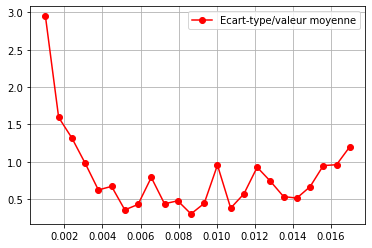

In [0]:
#Ajuster mu 

M= int(1e4)
P0= 35
N=100
n=10
liste_mu = np.linspace(0.001,0.017,24)
estimateurs = np.zeros((len(liste_mu),n))

for i in range(len(liste_mu)):
    for j in range(n):
        estimateurs[i,j]=part_interaction(N,saut_2_vect,P0,M,alpha,liste_mu[i])

plt.plot( liste_mu,np.std(estimateurs,axis=1)/np.mean(estimateurs,axis=1),'r-o',label="Ecart-type/valeur moyenne")

plt.grid()
plt.legend()

### Estimation de quantiles du prix final après N sauts

In [0]:
#Quantile simple 


def Quantile_naif_2(seuil,N,saut,P0,M,alpha):

    liste_P_t = np.zeros(M)
    for i in range(M):
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
        signes[0] = -1+np.random.binomial(1,0.5)*2
        signes = np.cumprod(signes)
        increments = saut(N)
        
        liste_P_t[i] = np.sum(increments*signes)+P0 
    liste_P_t = np.sort(liste_P_t)
    return liste_P_t[int(np.ceil(M*seuil))-1],liste_P_t[int(np.ceil(M*(1-seuil)))-1]

In [0]:
seuil = 1e-4
M=int(1e4)
nbIter = 10
quantiles = np.zeros((nbIter,2))

for i in range(nbIter):
    quantiles[i][0],quantiles[i][1] = Quantile_naif_2(seuil,N,saut_1,P0,M,alpha)

estimateur_quantiles = np.mean(quantiles,axis=0)
erreur = np.std(quantiles,axis=0)
print("Quantiles de niveau {} : ({} +/ {:08.7f}, {} +/ {})".format(alpha,estimateur_quantiles[0],erreur[0],estimateur_quantiles[1],erreur[1]))

Quantiles de niveau -0.875 : (24.2 +/ 0.9797958971132713, 45.4 +/ 1.2)


In [0]:
print("Quantiles de niveau {} : ({} +/ {:04.3f}, {} +/ {})".format(alpha,estimateur_quantiles[0],erreur[0],estimateur_quantiles[1],erreur[1]))

Quantiles de niveau -0.875 : (24.2 +/ 0.980, 45.4 +/ 1.2)


### Limite macroscopique

In [0]:
#Monte-Carlo 

def Q3_proba_negatif(lamb,T,saut,P0,M,alpha): 
    liste_px_inf_0 = np.zeros(M)
    for i in range(M):
        N = np.random.poisson(lamb*T)
        increments = saut(N)
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
        signes[0] = -1+np.random.binomial(1,0.5)*2
        signes = np.cumprod(signes)
        prix = P0 +np.cumsum(increments*signes)
        if np.min(prix)<0:
            liste_px_inf_0[i] = 1
        liste_px_inf_0[i] = 0
    return np.mean(liste_px_inf_0)

In [0]:
T = 8*250*24*60*60
lamb = 1/300
M = int(1e3)
P0=1000
alpha=-0.85

proba_negatif = Q3_proba_negatif(lamb,T,saut_2,P0,M,alpha)
print(proba_negatif)

0.0
